# Assignment 8: Neural Networks and Backpropagation
In this assignment, you will be asked to write your own code to implement the learning process of a simple neural network. We will use a simple version of [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which we have introduced in Assignment 6. To make the problem simpler, we only take images with label '8' and '9', which gives us a binary classification problem. Then we subsample the dataset and reduce the dimension of each image using average pooling. The following code loads the dataset and prints its dimension.

Similar to Assignment 3, you will need to implement forward and back-propagation. We define the following terms:

$n$ - the dataset size. For the training set $n=964$

$d$ - feature dimension. In this dataset $d=196$

$X\in\mathbb{R}^{d\times n}$ - the dataset written in a $d\times n$ matrix where the $i$-th column is the feature vector $x_i\in\mathbb{R}^d$ of data $i$.

$Y\in\{0, 1\}^n$ - the labels of all data.


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
#Load data
import scipy.io as sio
a = sio.loadmat('mnist_binary.mat')
X_trn = a['X_trn']
X_tst = a['X_tst']
Y_trn = a['Y_trn'][0]
Y_tst = a['Y_tst'][0]
print(X_trn.shape)
print(X_tst.shape)
print(Y_trn.shape)
print(Y_tst.shape)

(196, 964)
(196, 414)
(964,)
(414,)


## Requirements
1. You are not allowed to use any machine learning libraries which have neural networks implemented.

2. Notice here most of the problems you have will be regarding the dimensions of variables. In each skeleton function we provide, we have one assert line to help you verify whether you write your code correctly. Passing the assert line doesn't mean your code is correct. But it is a necessary condition.

3. You don't need to strictly follow the skeleton we provide. As long as you answer the problems correctly, you can write in any style you prefer.

## Parameters
Let's first implement a simple neural network with one hidden layer and one output layer. The hidden layer only has $n_h$ neurons. We assume the output layer has two neurons. Hence you will have 4 parameters to describe the neural network: 

1. $W_1$, a $n_h$ by $d=196$ matrix, which is the weight matrix between features and the hidder layer.
2. $b_1\in\mathbb{R}^{n_h}$, which is the offset for the first layer.
3. $W_2$, a 2 by $n_h$ matrix, which is the weight matrix between the hidder layer and the output layer.
4. $b_2\in\mathbb{R}^2$, which is the offset for the second layer.

The following script initializes the above four parameters and returns them as a dictionary.

In [3]:
#Initialize parameters 
num_hidden = 20 #number of neurons in the hidden layer
num_op = 2 #number of neurons in the output layer

def initialize_parameters(size_input, size_hidden, size_output):
    np.random.seed(2)
    W1 = np.random.randn(size_hidden, size_input) * 0.01
    b1 = np.zeros(shape=(size_hidden, 1))
    W2 = np.random.randn(size_output, size_hidden) * 0.01
    b2 = np.zeros(shape=(size_output, 1))
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    return parameters
parameters = initialize_parameters(X_trn.shape[0], num_hidden, num_op)
print('W1',parameters['W1'].shape)
print('b1',parameters['b1'].shape)
print('W2',parameters['W2'].shape)
print('b2',parameters['b2'].shape)

W1 (20, 196)
b1 (20, 1)
W2 (2, 20)
b2 (2, 1)


Denote the activation function as $\sigma$ which will be specified later. Given the i'th data $x_i\in \mathbb{R}^d$, the neural network produces an output $\hat{y}_i\in(0, 1)$ as follows: 
$$
Z_1^{(i)}=W_1x_i+b_1,
$$
$$
A_1^{(i)}=\sigma(Z_1^{(i)}),
$$
$$
Z_2^{(i)}=W_2A_1^{(i)}+b_2.
$$
$$
\hat{y}_i=A_2^{(i)}:=\text{Softmax}(Z_2^{(i)}).
$$
Note that the final layer does not have an activation. The first step is to implement the necessary functions needed for forward pass.

## Softmax function.
Let $Z_2=(z_1, z_2)$ be the final output layer of neurons. The softmax outputs are probability estimates for outputing label 1 (assuming '8' is 1 and '9' is zero):

$$\hat{y}_1 = \Pr(Y = 1 | z_1, z_2) = \frac{e^{z_1}}{e^{z_1} + e^{z_2}}$$

For time-efficiency, we want to perform computations for the entire dataset. Denote $Z_2=(Z_2^{(1)}, \ldots, Z_2^{(n)})$ which is a matrix of shape $2 \times n$, and each column $Z_2^{(i)}$ is assumed to be the output of the final layer of the neural network. Your output should be $A_2=(\hat{y}_i, \ldots, \hat{y}_n)$, which has shape $1 \times n$.

Write code in the cell below to do the softmax computation

In [4]:
def softmax(Z2):
    # ip - (M,N) array where M is no. of neurons in output layer, N is number of samples.
    # You can modify the code if your output layer is of different dimension
    # =========Write your code below ==============

    softmax = np.zeros((1, Z2.shape[1]))
    
    #for i in range(Z2.shape[1]):
        #softmax[0][i] = np.exp(Z2[0][i]) / ((np.exp(Z2[0][i]) + np.exp(Z2[1][i])))
    softmax[0] = np.exp(Z2[0]) / ((np.exp(Z2[0]) + np.exp(Z2[1])))    
        
    # =============================================
    assert(softmax.shape == (1, Z2.shape[1]))
    return softmax

## Activation function.
The following function should be able to implement activation function given the input. An activation function is a one-variable real-valued function denoted as $\sigma:\mathbb{R}\mapsto \mathbb{R}$. For notation simplicity, given a matrix $A$, we denote $\sigma(A)$ as applying the function $\sigma$ to each element of $A$, i.e., $\sigma(A)$ is a matrix with the same dimension as $A$ where each element is defined as
$$
\sigma(A)_{ij}:=\sigma(A_{ij})
$$

Complete the activation function below. We will use $\text{ReLU}$ and $\text{Sigmoid}$ as our activation functions where for $x\in\mathbb{R}$, 
$$
\text{ReLU}(x)=\max\{0, x\},\quad \text{Sigmoid}(x)=\frac{1}{1+e^{-x}}
$$

In [5]:
def activ(ip,act):
    # ip - array obtained after multiplying inputs with weights (between input layer and hidden layer)
    # act - ReLU or Sigmoid
    
    out = np.zeros((ip.shape[0], ip.shape[1]))
    
    if act =="ReLU":
        # =========Write your code below ==============

        out = np.maximum(0, ip)    

        # =============================================
        
    elif act == "Sigmoid":
        # =========Write your code below ==============
        
        out = 1 / (1 + np.exp(-ip))

        # =============================================
    assert(out.shape == ip.shape)
    return out

## Forward Propagation
Given $X, W_1, b_1, W_2, b_2$, the following function will compute the neurons and activated values in the hidden layer, denoted by $Z_1, A_1$ respectively. $Z_1, A_1$ are defined similarly as $Z_2$,
$$
Z_1=(Z_1^{(1)}, \ldots, Z_1^{(n)}), \quad A_1=(A_1^{(1)}, \ldots, A_1^{(n)})
$$
It will also return the neurons in the last layer and the softmax function computed from it, denoted by $Z_2, A_2$ respectively. 

In [6]:
#Forward Propagation   
def forward_propagation(X, parameters, act):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # =========Write your code below ==============
    
    Z1 = np.dot(W1, X) + b1
    A1 = activ(Z1, act)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)

    # =============================================
    
    assert(A2.shape == (1, X.shape[1]))
    
    neuron = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return neuron

## Backward propagation
In this assignment, we will use the cross-entropy loss defined below as our loss function. Suppose that for data $x\in \mathbb{R}$, $Z=(z_1, z_2)$ is the final layer of neurons, and after softmax we obtain $\hat{y}$ which corresponds to the probability of label 8. Let $y$ be the true labels (assume 1 for '8', 0 for '9')
$$\ell(y,\hat{y}) = -y\log(\hat{y}) - (1-y_i)\log(1-\hat{y}),$$
where $$\hat{y} = \text{Softmax}(Z)=\frac{e^{z_1}}{e^{z_1} + e^{z_2}}.$$

You have shown in the assignment that:
$$\frac{\partial \ell(y,\hat{y})}{\partial z_1} = \hat{y} - y, \frac{\partial \ell(y,\hat{y})}{\partial z_2} = y - \hat{y}.$$

Similar to the logistic regression assignment, during training we wish to minimize the following loss function,
$$
L(X, Y; \theta)=\frac{1}{n}\sum_{i=1}^n\ell(y_i, \hat{y}_i).
$$
Given the parameters and the neuron values, we wish to calculate the gradient of the loss function w.r.t all the parameters $W_1, b_1, W_2, b_2$ using backward propagation. Note here, all the gradients should be of the same dimension as the corresponding parameters. 

$$
Z_1^{(i)}=W_1x_i+b_1,
$$
$$
A_1^{(i)}=\sigma(Z_1^{(i)}),
$$
$$
Z_2^{(i)}=W_2A_1^{(i)}+b_2.
$$
$$
\hat{y}_i=A_2^{(i)}:=\text{Softmax}(Z_2^{(i)}).
$$

W1 (20, 196=d)
b1 (20, 1)
W2 (2, 20)
b2 (2, 1)

$n$ - the dataset size. For the training set $n=964$

$d$ - feature dimension. In this dataset $d=196$

$X\in\mathbb{R}^{d\times n}$ - the dataset written in a $d\times n$ matrix where the $i$-th column is the feature vector $x_i\in\mathbb{R}^d$ of data $i$.

$Y\in\{0, 1\}^n$ - the labels of all data.

Z1 = (20 x n)
A1 = (20 x n)
Z2 = (2 x n)
A2 = (1 x n)

In [7]:
def backprop(parameters, neuron, X, Y, act):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = neuron['A1']
    A2 = neuron['A2']
    Z1 = neuron['Z1']
    Z2 = neuron['Z2']
# =========Write your code below ==============
    

    dL_dZ2 = np.zeros((2, Y.shape[0]))
    # dL_dz1 = Y_hat - Y, 2xn
    dL_dZ2[0] = (A2[0] - Y.T) / Y.shape[0]
    # dL_dz2 = Y - Y_hat
    dL_dZ2[1] = (Y.T - A2[0]) / Y.shape[0]

    # dL_dW2 (2, 20) = dL_dZ2 * dZ2_dW2 = dL_dZ2 * A1
    dW2 = np.dot(dL_dZ2, A1.T) # 2xn * 20xn.T = 2xn * nx20
    
    # dL_db2 (2, 1) = dL_dZ2 * dZ2_db2 = dL_dZ2 * 1
    db2 = np.dot(dL_dZ2, np.ones((Y.shape[0], 1))) # 2xn * n*1     Y.shape or X.shape
    
    # dL_dA1 (20, n) = dL_dZ2 * dZ2_dA1
    dL_dA1 = np.dot(W2.T, dL_dZ2) # 20x2 * 2xn
    
    if act == "ReLU":
        # dA_dZ1 (20, n)
        dA_dZ1 = np.zeros(Z1.shape)
        dA_dZ1 = np.heaviside(Z1, dA_dZ1)
            
    elif act == "Sigmoid":
        # dA_dZ1 (20, n)
        dA_dZ1 = np.zeros(Z1.shape)
        #for i in range(Z1.shape[0]):
            #for j in range(Z1.shape[1]):
        dA_dZ1 = (1.0 / (1 + np.exp(-Z1))) * (1 - (1.0 / (1 + np.exp(-Z1))))

    #dL_dW1 (20, d) = dL_dZ2 * dZ2_dA1 * dA1_dZ1 * dZ1_dW1(X) = dL_dA1 *  dA1_dZ1 * dZ1_dW1(X)
    dW1 = np.dot(np.multiply(dL_dA1, dA_dZ1), X.T) # 20xn x 20xn * nxd(T) = 20xd
                
    #dL_db1 (20, 1) = dL_dZ2 * dZ2_dA1 * dA1_dZ1 * dZ1_db1 = dL_dA1 *  dA1_dZ1 * dZ1_db1
    db1 = np.dot(np.multiply(dL_dA1, dA_dZ1), np.ones((X.shape[1], 1))) # 20xn x 20xn * nx1 = 20x1
    
    # =============================================
    
    assert(dW1.shape == W1.shape)
    assert(dW2.shape == W2.shape)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW1'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW2'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db1'].shape)
#print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db2'].shape)

def cross_entropy_loss(softmax, Y):
# =========Write your code below ==============

    loss = np.zeros(Y.shape)
    ones_arr_y = np.ones(Y.shape[0])
    ones_arr_s = np.ones((softmax.shape[0], softmax.shape[1]))
    
    # y is in n x 1 dim
    # yhat is 1 x n dim
    #for i in range(Y.shape[0]):
        #loss[i] = (-(Y[i]) * np.log(softmax[0][i])) - ((1 - Y[i]) * np.log(1 - softmax[0][i]))
        
    loss = (-Y * np.log(softmax[0])) - ((1 - Y) * np.log(ones_arr_s[0] - softmax[0]))

# =============================================        
    assert(loss.shape == Y.shape)
    return loss

## Parameter updates
Given the parameters and the gradients, we simply update the parameters by the following:

$$W = W - \eta dW$$

where $\eta$ is the learning rate.

In [8]:
def update_parameters(parameters, grads, learning_rate):

# =========Write your code below ==============

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    #print(W1)
    #print("=======")
    W1 = W1 - learning_rate * grads["dW1"]
    b1 = b1 - learning_rate * grads["db1"]
    W2 = W2 - learning_rate * grads["dW2"]
    b2 = b2 - learning_rate * grads["db2"]
    #print(W1)
    #print("===============")
    
# =============================================

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Neural network models
Combining the above mentioned parameters, implement the following function to learn a neural network and do inference on it. Given a predicted probability $\hat{y}$, obtain a predicted label in $\{0, 1\}$ by comparing $\hat{y}$ to 1/2.

In [9]:
from sklearn.metrics import accuracy_score
def nn_model1(X_trn, X_tst, Y_trn, Y_tst, n_h, n_o, epochs, act, learning_rate):
    #X_trn: the training set
    #X_tst: the test set
    #Y_trn: training labels
    #Y_tst: test labels
    #n_h: number of neurons in the hidden layer
    #n_o: number of neurons in the output layer
    #epochs: number of epochs for the training
    #act: the activation function you choose
    #learning_rate: a list of length epochs, which consists of the learning rate in each step
    
    assert(len(learning_rate) == epochs)
    
   # =========Write your code below ==============

    def prediction(X, Y, parameters, act):
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        
        pred = np.zeros(Y.shape)
        
        Z1 = np.dot(W1, X) + b1
        A1 = activ(Z1, act)
        Z2 = np.dot(W2, A1) + b2
        A2 = softmax(Z2)
        
        for i in range(Y.shape[0]):
            #print(Z2[0][i])
            if A2[0][i] >= 0.5:
                pred[i] = 1
            else:
                pred[i] = 0
        return pred        
    
    parameters = initialize_parameters(X_trn.shape[0], n_h, n_o)
    err_tst = np.zeros(epochs)
    err_trn = np.zeros(epochs)
    loss_trn = np.zeros(epochs)
    
    for i in range(epochs):
        neuron = forward_propagation(X_trn, parameters, act)
        grads = backprop(parameters, neuron, X_trn, Y_trn, act)
        parameters = update_parameters(parameters, grads, learning_rate[i])

        loss_trn[i] = np.sum(cross_entropy_loss(neuron['A2'], Y_trn)) / len(Y_trn)
        err_trn[i] = (1-accuracy_score(Y_trn, prediction(X_trn,Y_trn,parameters,act)))
        err_tst[i] = (1-accuracy_score(Y_tst, prediction(X_tst,Y_tst,parameters,act)))
        #print(loss_trn[i])
    

    # =============================================    
    #err_tst: testing error (classification error) in each epoch
    #err_trn: training error (classification error) in each epoch
    #loss_trn: training loss (cross entropy loss) in each epoch
    #parameters: the final learned parameters
    return err_tst, err_trn, loss_trn, parameters

## Problem 0: Verify that your code is working well.
Using ReLU (Sigmoid) as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Set the number of epochs to be 20000. Plot the cross entropy loss at each epoch to convince yourself that you are training well. (Your cross entropy loss should be decreasing smoothly. This part won't be graded.)

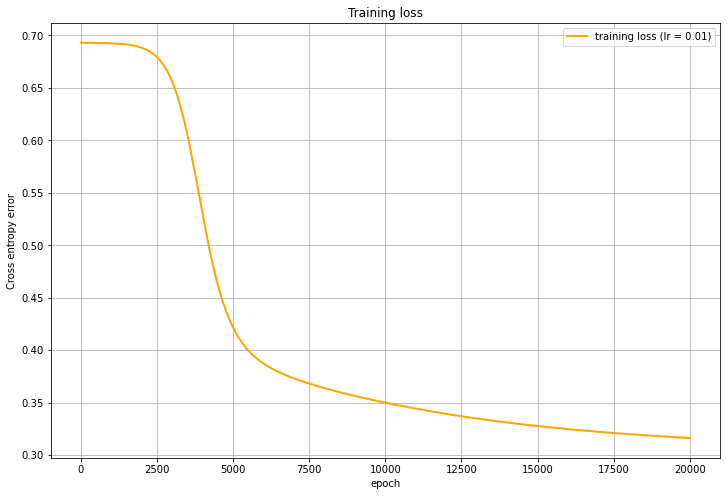

In [50]:
epochs = 20000
lr1 = 0.01*np.ones(epochs)
# =========Write your code below ==============

err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, "ReLU", lr1)

# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), loss_trn, '-', color='orange',linewidth=2, label='training loss (lr = 0.01)')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('Cross entropy error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 1: Learning with fixed learning rate.
Using ReLU as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Plot the training and testing error (classification error) you get at each epoch. Justify your plot. (Set the number of hidden neurons in the hidden layer to be 20 for problem 1-3, for all problems below, set epochs = 20000).

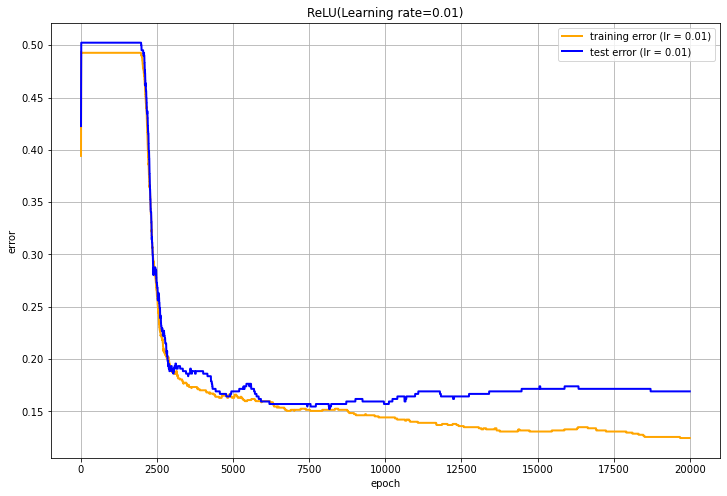

In [10]:
epochs = 20000
lr1 = 0.01*np.ones(epochs)
# =========Write your code below ==============

err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, "ReLU", lr1)

# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')
#plt.plot(range(epochs), trn_loss, '-r', linewidth=2, label='loss (lr = 0.01)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

In the early iterations of gradient descent (epoch between 0-2000), we can see that both the training and testing error stays constant at around 0.49 and 0.5. Then, when the epoch is at around 2000, we can immediately see a drastic decrease in both errors. The rate of error decrease started to slow down at epoch = 2700. At around epoch = 7500, we noticed how the model started to overfit. The training error continue to decrease while the testing error started to slowly increase. At this point, as we continue to perform the next iterations of epoch, the model gets too complex and is not learning anything meaningful that can help predict test data.

# Problem 2: 
Using ReLU as your activation function, change the learning rate to $\eta = 0.1$. Plot the plots on the same figure as in problem 1. Compare the plots and justify.

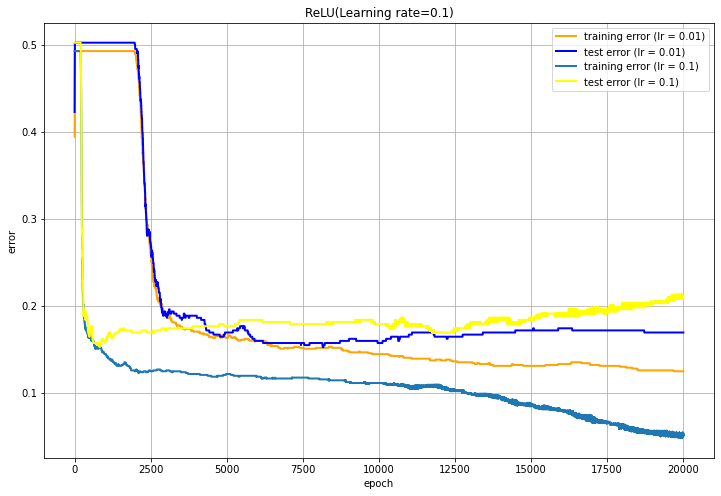

In [49]:
lr2 = 0.1*np.ones(epochs)
# =========Write your code below ==============

err_tst2, err_trn2, loss_trn2, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, "ReLU", lr2)

# =============================================
plt.figure(2, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2,  label='test error (lr = 0.1)')

plt.title('ReLU(Learning rate=0.1)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

When the learning rate is increased from 0.01 to 0.1, we can see that both the training and testing error will decrease faster/earlier (at a lower epoch), thus this is actually a good thing. However, when epoch = 1000, we can see that the model overfits, in which the testing error started to increase while the training error continue to decrease. Comparing the two plots, we can see that the model with higher learning rate overfits more (comparing yellow and blue line). Additionally, we can see from the plot that when using a smaller learning rate, although the test error decreases slower, but we can actually get a better performance compared to when using a higher learning rate. As a result, this is the tradeoffs that we will ahve to consider.

# Problem 3: Learning with variable learning rate.
Using ReLU as your activation function, implement a learning algorithm with variable learning rate $\eta = \frac1{\sqrt{i+1}}$ at the $i$th step. Plot the training and testing error you get at each iteration and compare it with the plots you get previously. Justify your plot.

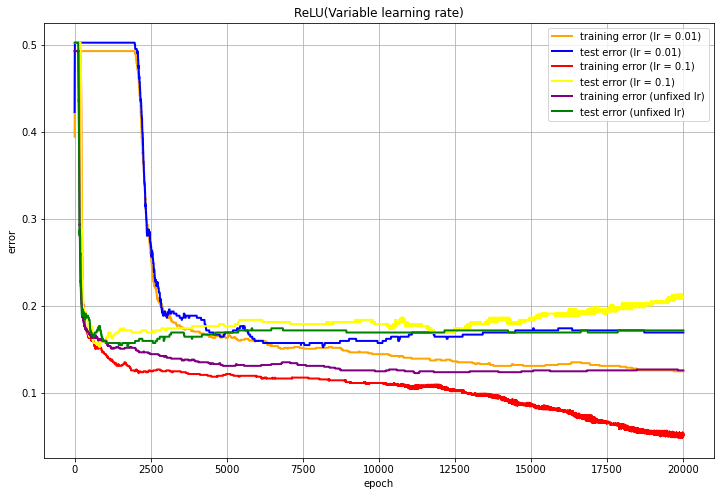

In [51]:
indices = np.array(range(epochs))
lr3 = 1/np.sqrt(indices + 1)
# =========Write your code below ==============

err_tst3, err_trn3, loss_trn3, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, "ReLU", lr3)

# =============================================
plt.figure(3, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', color='red', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2, label='test error (lr = 0.1)')

# Classification errors for variable learning rate, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn3, '-', color='purple', linewidth=2, label='training error (unfixed lr)')
plt.plot(range(epochs), err_tst3, '-b', color='green', linewidth=2, label='test error (unfixed lr)')
plt.title('ReLU(Variable learning rate)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

The figure above compare the plots of using a lower, higher, and variable learning rate. From problem 2, we have learned that when using the higher learning rate = 0.1, we are able to get a low test error quicker (less epoch) but then the model will overfit more and overfit earlier too. On the figure above, we can see that when using variable learning rate, we are able to also immediately decrease both the training and testing rate. Then, at around epoch = 2000, we can see that the model starts to overfit. However, we can see that the overfitting with variable learning rate would make it to have a similar testing error to learning rate = 0.01 and not as hight as when learning rate = 0.1. This shows that using variable learning rate is beneficial because we are able to decrease the test error quickly like a higher learning rate as well as to maintain less overfitting like a lower learning rate.

# Problem 4: Larger hidden layer.
Change the number of neurons in the hidden layer to be $50$. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

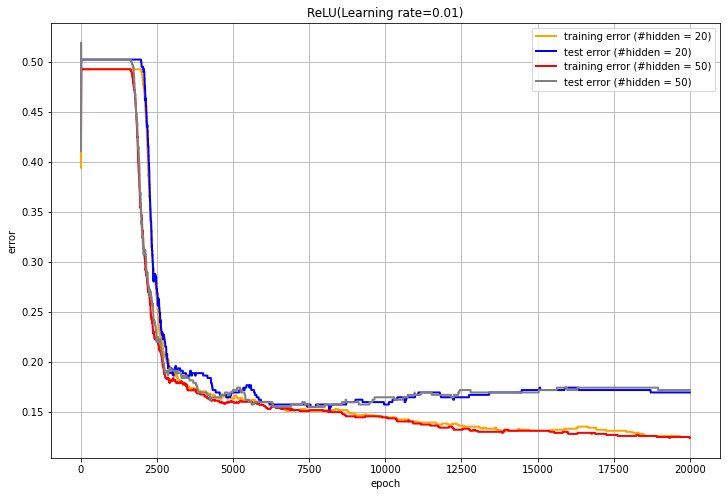

In [16]:
num_hidden2 = 50
# =========Write your code below ==============

err_tst4, err_trn4, loss_trn4, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, num_hidden2, 2, epochs, "ReLU", lr1)

# =============================================
plt.figure(4, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (#hidden = 20)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (#hidden = 20)')

# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 50
plt.plot(range(epochs), err_trn4, '-', color='red', linewidth=2, label='training error (#hidden = 50)')
plt.plot(range(epochs), err_tst4, '-b', color='grey', linewidth=2, label='test error (#hidden = 50)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

Looking at the plot above, the first thing that we can see is that the training and testing error decreases earlier (at lower epoch) when hidden layer = 50 compared to when hidden layer = 20, although not by much. Other than that, starting at epoch = 5000, their errors are very similar. What I was expecting to see is on how using a higher hidden layer may cause the model to overfit more as it is more complex, which means a higher testing error and lower training error. However, it is possible that we would need higher hidden layer or higher epoch in order to see that phenomena. It makes sense to think that more hidden layers would make the model more complex and to overfit more.

# Problem 5: Sigmoid Activation.
Change the activation function to be Sigmoid function. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

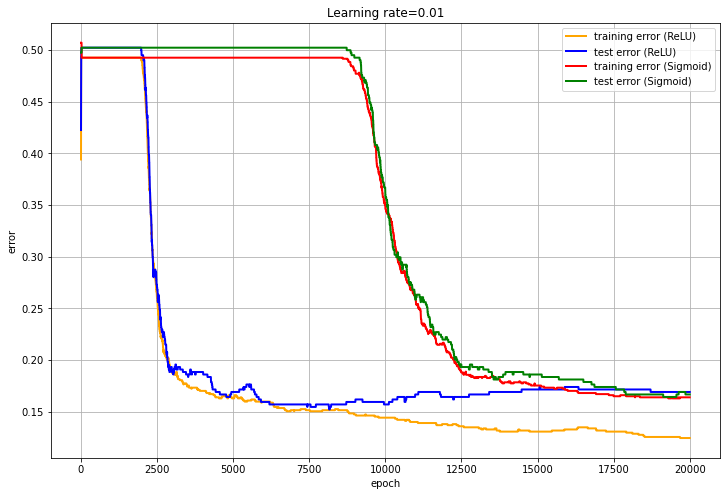

In [53]:
# =========Write your code below ==============

err_tst5, err_trn5, loss_trn5, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, "Sigmoid", lr1)

# =============================================
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.figure(5, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (ReLU)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (ReLU)')

# Classification errors for learning rate = 0.01, Sigmoid Activation, n_hidden = 20
plt.plot(range(epochs), err_trn5, '-', color='red',  linewidth=2, label='training error (Sigmoid)')
plt.plot(range(epochs), err_tst5, '-b', color='green', linewidth=2, label='test error (Sigmoid)')

plt.title('Learning rate=0.01')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

From the figure above, we can see that using ReLu allows the testing and training error to decrease more quickly at epoch = 2000. On the other hand, when using Sigmoid activation function, the errors will only start to decrease at apoch = 8500. In the ReLu plot, we can clearly see the overfitting starting to happen at epoch = 7500, however we would need to have a higher range of epoch in order to see the overfitting when using a Sigmoid function. The plot above shows that when using the same learnign rate, ReLu activation allows the model to be quicker in decreasing the testing error (lower epoch). It also in a way tells us that Sigmoid may require a higher learning rate to be able to quickly lower the errors and predict well.